In [2]:
import math, random
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d

%matplotlib inline




## Rejection-free Lévy Path Integral Sampling

In [3]:
def levy_harmonic_path(k, beta):
    xk = tuple([random.gauss(0.0, 1.0 / math.sqrt(2.0 *
                math.tanh(k * beta / 2.0))) for d in range(3)])
    x = [xk]
    
    for j in range(1, k):
        Upsilon_1 = (1.0 / math.tanh(beta) +
                     1.0 / math.tanh((k - j) * beta))
        Upsilon_2 = [x[j - 1][d] / math.sinh(beta) + xk[d] /
                     math.sinh((k - j) * beta) for d in range(3)]
        
        x_mean = [Upsilon_2[d] / Upsilon_1 for d in range(3)]
        sigma = 1.0 / math.sqrt(Upsilon_1)
        dummy = [random.gauss(x_mean[d], sigma) for d in range(3)]
        x.append(tuple(dummy))
    return x
 
    
def rho_harm(x, xp, beta):
    Upsilon_1 = sum((x[d] + xp[d]) ** 2 / 4.0 *
                    math.tanh(beta / 2.0) for d in range(3))
    Upsilon_2 = sum((x[d] - xp[d]) ** 2 / 4.0 /
                    math.tanh(beta / 2.0) for d in range(3))
    return math.exp(- Upsilon_1 - Upsilon_2)

In [4]:
def get_positions(N = 256, nsteps = 100000, T_star = 0.6):
    beta = 1.0 / (T_star * N ** (1.0 / 3.0))
    positions = {}

    for j in range(N):
        a = levy_harmonic_path(1, beta)
        positions[a[0]] = a[0]

    for step in range(nsteps):
        boson_a = random.choice(positions.keys())
        perm_cycle = []

        while True:
            perm_cycle.append(boson_a)
            boson_b = positions.pop(boson_a)
            if boson_b == perm_cycle[0]: break
            else: boson_a = boson_b

        k = len(perm_cycle)
        perm_cycle = levy_harmonic_path(k, beta)
        positions[perm_cycle[-1]] = perm_cycle[0]

        for j in range(len(perm_cycle) - 1):
            positions[perm_cycle[j]] = perm_cycle[j + 1]

        a_1 = random.choice(positions.keys())
        b_1 = positions.pop(a_1)
        a_2 = random.choice(positions.keys())
        b_2 = positions.pop(a_2)
        weight_new = rho_harm(a_1, b_2, beta) * rho_harm(a_2, b_1, beta)
        weight_old = rho_harm(a_1, b_1, beta) * rho_harm(a_2, b_2, beta)

        if random.uniform(0.0, 1.0) < weight_new / weight_old:
            positions[a_1] = b_2
            positions[a_2] = b_1
        else:
            positions[a_1] = b_1
            positions[a_2] = b_2
            
    return positions

In [5]:
def plot_result(positions, T_star):
    fig = plt.figure()
    ax = mpl_toolkits.mplot3d.axes3d.Axes3D(fig)
    ax.set_aspect('equal')
    list_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    n_colors = len(list_colors)
    dict_colors = {}
    i_color = 0
    
    while positions:
        x, y, z = [], [], []
        starting_boson = positions.keys()[0]
        boson_old = starting_boson

        while True:
            x.append(boson_old[0])
            y.append(boson_old[1])
            z.append(boson_old[2])
            boson_new = positions.pop(boson_old)
            if boson_new == starting_boson: break
            else: boson_old = boson_new
                
#         number of all possible permutations
        len_cycle = len(x) 
#         print len_cycle

#         cycle closure
        if len_cycle > 2:
            x.append(x[0])
            y.append(y[0])
            z.append(z[0])

        if len_cycle in dict_colors:
            color = dict_colors[len_cycle]
            ax.plot(x, y, z, color + '+-', lw=0.75)
            
#         the choice of color takes place in order
        else:
            color = list_colors[i_color]
            i_color = (i_color + 1) % n_colors
            dict_colors[len_cycle] = color  
            ax.plot(x, y, z, color + '+-', label='k=%i' % len_cycle, lw=0.75) 

#     print color
    plt.title('$N=%i$, $T^*=%s$' % (N, T_star))
    plt.legend()
    ax.set_xlabel('$x$', fontsize=16)
    ax.set_ylabel('$y$', fontsize=16)
    ax.set_zlabel('$z$', fontsize=16)
    ax.set_xlim3d([-8, 8])
    ax.set_ylim3d([-8, 8])
    ax.set_zlim3d([-8, 8])
    plt.savefig('snapshot_bosons_3d_N%04i_Tstar%04.2f.png' % (N, T_star))
    plt.show()

In [6]:
# print positions.keys()
# copy_positins = positions.copy()
# matrix = np.asanyarray(positions.items())
# print matrix[0]
# print matrix[1][0]

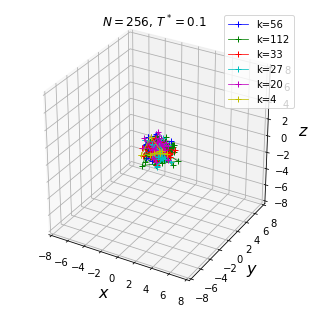

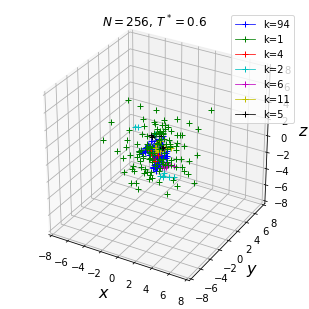

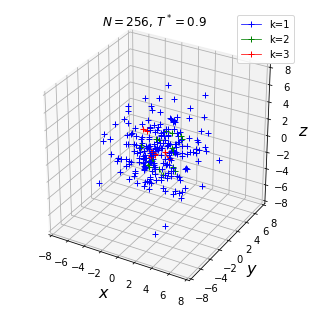

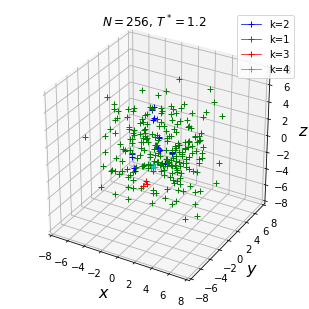

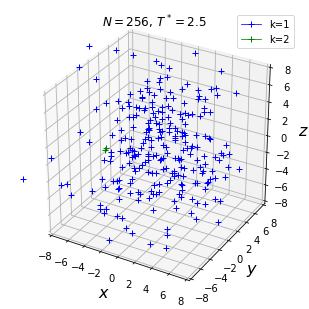

In [9]:
N = 256
temperatures = np.array([0.1, 0.6, 0.9, 1.2, 2.5])
    
for T in temperatures:
    positions = get_positions(nsteps = 150000, T_star = T)
    plot_result(positions, T)
    